In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./nonlin')
sys.path.append('./partion')
sys.path.append('./1D-difusion')

from aspen import aspen
from newton import newton

import partion

from one_phase import one_phase
import numpy as np
import matplotlib.pyplot as plt

### Начальные условия и модель

In [2]:
def model(u):
    return np.array([u**2+1, 2*max(u, 0)])

class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

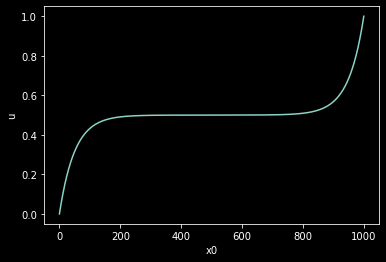

In [3]:
plt.style.use('dark_background')
# inital condition
Nx = 1000
Nt = 100

D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)
bd1 = 0
bd2 = 1

x0 = np.arange(Nx)/(Nx-1)
x0 = np.sinh(20*(x0-0.5))
x0 /= np.max(x0)
x0 = (x0+1)/2
x0 = np.reshape(x0, (-1, 1))
plt.xlabel('x0')
plt.ylabel('u')
plt.plot(x0)

setInitial = lambda x: x#.setInitial(0.2, 1, 1) 
setSources = lambda x: x#.setSources([0.9], [-17.9])

Такое начальное условие выбрано для динамики, позднее на графиках будет видно как решение меняется по времени

In [4]:
param = {
    'Nx': Nx, 
    'Nt': Nt,
}
t_new = np.inf
for k in range(5):
    nl_solver = newton(1e-2, kmax = 14, crit_abs = 1e-3)
    solver_cl = one_phase(param, D, nl_solver)
    solver_cl.init_log()
    solver_cl.setBoundary(bd1, bd2)
    solver_cl.x0 = np.copy(x0)
    #setInitial(solver_cl)
    setSources(solver_cl)

    X_cl, code, message = solver_cl.solve()
    t = solver_cl.timelog.res+solver_cl.timelog.jac \
      +solver_cl.timelog.lin
    if t < t_new:
        t_new = np.copy(t)
print(message)
print('mean newton iterations: ', np.mean(solver_cl.timelog.kn))
print('best time:', t_new)

newton log initialized
newton log initialized
newton log initialized
newton log initialized
newton log initialized
OK
mean newton iterations:  4.11
best time: 66.83894205093384


In [5]:
Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt
}
t_eq = np.inf
for k in range(5):
    part = partion.partion_equally(Nx, Nd)
    nl_solver = aspen(Nd, part, 1e-2, crit_abs = 1e-3)
    solver_as = one_phase(param, D, nl_solver)
    solver_as.init_log()
    solver_as.setBoundary(bd1, bd2)
    solver_as.x0 = np.copy(x0)
    #setInitial(solver_as)
    setSources(solver_as)
    
    X, code, message = solver_as.solve()
    t = solver_as.timelog.gb_res+solver_as.timelog.gb_jac \
      +solver_as.timelog.gb_lin+np.sum(solver_as.timelog.lc_res) \
      +np.sum(solver_as.timelog.lc_jac)+np.sum(solver_as.timelog.lc_lin)
    if t < t_eq:
        t_eq = np.copy(t)
print(message)
print('mean aspen iterations: ', np.mean(solver_as.timelog.aspen_iters))
print('best time:', t_eq)

ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
OK
mean aspen iterations:  1.0
best time: 65.92048025131226


### Графики решения

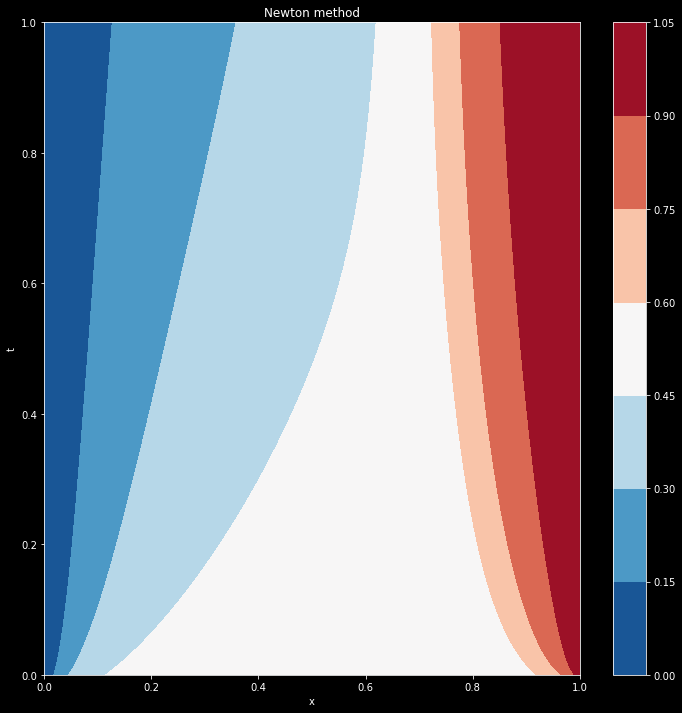

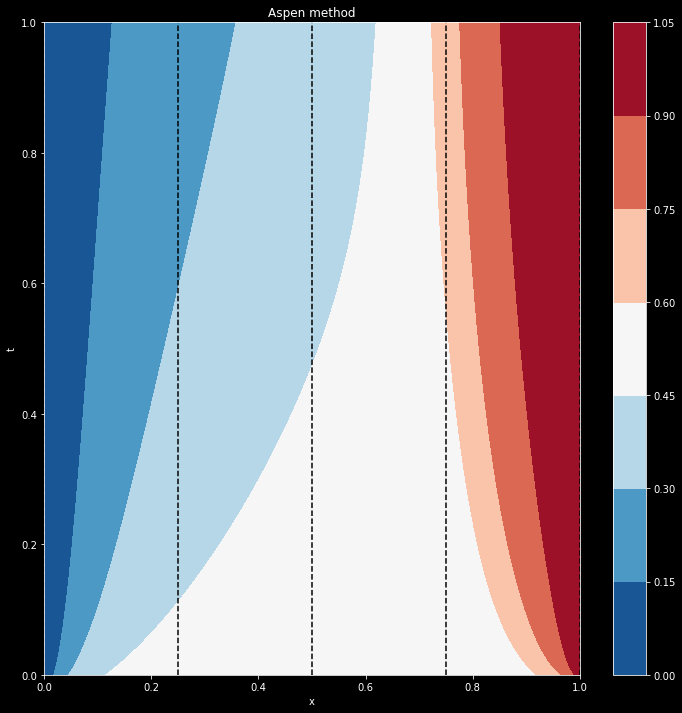

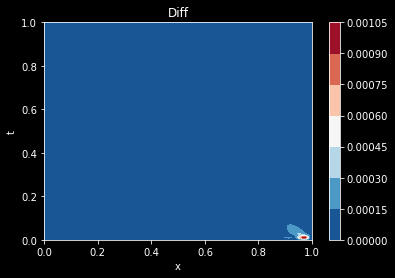

In [6]:
x = np.linspace(0, 1, Nx)

plt.figure(figsize= (12, 12))
plt.xlabel('x')
plt.ylabel('t')
plt.title('Newton method')
t = solver_cl.t
x_grid, t_grid = np.meshgrid(x, t)
cs = plt.contourf(x_grid, t_grid, X_cl.T, cmap='RdBu_r')
cbar = plt.colorbar(cs)
plt.show()

plt.figure(figsize= (12, 12))
plt.xlabel('x')
plt.ylabel('t')
plt.title('Aspen method')
t = solver_as.t
x_grid, t_grid = np.meshgrid(x, t)
cs = plt.contourf(x_grid, t_grid, X.T, cmap='RdBu_r')
cbar = plt.colorbar(cs)
# plot domain borders
part = partion.partion_equally(Nx, Nd)
for dom in part:
    plt.axvline(dom/Nx, linestyle='--', color='k')

plt.show()

plt.title('Diff')
plt.xlabel('x')
plt.ylabel('t')
t = solver_as.t
x_grid, t_grid = np.meshgrid(x, t)
cs = plt.contourf(x_grid, t_grid, (np.abs(X-X_cl)).T, cmap='RdBu_r')
cbar = plt.colorbar(cs)
plt.show()

Как видим а) присутсвует динамика по времени, имеющая локальный характер, б) решения двух алгоритмов отличаются в пределах погрешности

In [8]:
print('aspen equal/newton comparsion')
print('aspen equal = {}, newton = {}'.format(t_eq, t_new))

aspen equal/newton comparsion
aspen equal = 65.92048025131226, newton = 66.83894205093384


Хм, похоже что ускорения получилось добиться незначительного

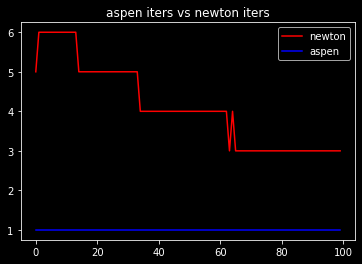

In [9]:
plt.title('aspen iters vs newton iters')
plt.plot(solver_cl.timelog.kn, color = 'r', label='newton')
plt.plot(solver_as.timelog.aspen_iters, color = 'b', label='aspen')
plt.legend()
plt.show()

Почти везде aspen справляется за одну иттерацию, когда метод Ньютона работает долго на начальных этапах задачи. Скорей всего, продолжи мы решения даже, вышли бы уже на почти стационарный участоток, где мало требуется мало иттераций

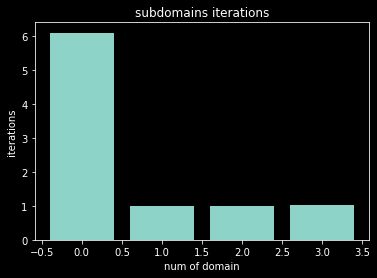

In [10]:
plt.title('subdomains iterations')
plt.xlabel('num of domain')
plt.ylabel('iterations')
plt.bar(np.arange(0, Nd, 1, dtype='int'), solver_as.timelog.domain_iters)
plt.show()

Во-первых, тут мы наблюдаем выделние домена с наибольшим число иттераций, во-вторых похоже что среднее число иттераций в нем превосходит среднее число иттераций в методе Ньютона, что еще раз подвтерждает версию о том, что ASPEN был эффективен на начальных этапах задачи. Вероятно, надо учиться делать динамические границы

### Тактики разбиения
На примере данной задачи будем тестить разные критерии разбиения на домены

##### Метод 1
$$
w(v, u) =  - |\frac{\partial R(u)}{\partial v}| - |\frac{\partial R(v)}{\partial u}| 
$$

$$
	\sum_{i=1}^k \sum_{v \in V_i} \sum_{u \in \Gamma(v), u \notin V_i} \frac{w(v, u)}{k} \rightarrow min
$$

Знак минус, внезапно, возник из корелляционного анализа. Будет видно позднее, как так получилось

In [11]:
def metrics_1(solver, X, domain_borders, Nt, t_step, show = False):
    nd = domain_borders.shape[0]-1
    val = 0
    for n_t in range(0, Nt+1, t_step):
        for i in range(1, nd):
            bd = domain_borders[i]
            val -= np.abs(solver.FluxJac(X[:, n_t], bd)[0, 1]) \
                +np.abs(solver.FluxJac(X[:, n_t], bd)[0, 0])

        #val /= (nd-1)
    val /= ((Nt+1)//t_step)

    return val

def neighbour(domain_borders):
    nd = domain_borders.shape[0]-1
    neig = np.copy(domain_borders)
    for i in range(1, nd):
        bd = neig[i]
        left = (bd-1 != neig[i-1])
        right = (bd+1 != neig[i+1])
        
        if left and right:
            neig[i] += np.random.randint(-1, 1)
        elif left:
            neig[i] += np.random.randint(-1, 0)
        elif right:
            neig[i] += np.random.randint(0, 1)
            
    return neig

In [13]:
# start value
part = partion.partion_equally(Nx, Nd)
print(part)
borders = np.copy(part)

T0 = 19600
val_start = metrics_1(solver_cl, X, borders, Nt, 1, show=True)
val_prev = np.copy(val_start)
for k in range(0, 320, 1):
    T = T0/(1.1**k)
    borders_new = neighbour(borders)
    val = metrics_1(solver_cl, X, borders_new, Nt, 1)
    if (val < val_prev) or (np.random.rand() < np.exp(-(val-val_prev)/(T))):
        borders = np.copy(borders_new)
        val_prev = np.copy(val)

        
val_end = metrics_1(solver_cl, X, borders, Nt, 1, show=True)
m1_optimal = np.copy(val_end)
print('before: {:.2f}'.format(val_start))
print('after: {:.2f}'.format(val_end))
if(val_start > val_end):
    print('it works!')
print(borders)

[   0  250  500  750 1000]
before: -345716.45
after: -450671.32
it works!
[   0  142  349  580 1000]


In [14]:
t_m1 = np.inf

for k in range(5):
    nl_solver = aspen(Nd, borders, 1e-2, crit_abs = 1e-3)
    solver_m1 = one_phase(param, D, nl_solver)
    solver_m1.init_log()
    solver_m1.setBoundary(bd1, bd2)
    solver_m1.x0 = np.copy(x0)
    #setInitial(solver_as)
    
    setSources(solver_m1)
    X, code, message = solver_m1.solve()
    t = solver_m1.timelog.gb_res+solver_m1.timelog.gb_jac \
      +solver_m1.timelog.gb_lin+np.sum(solver_m1.timelog.lc_res) \
      +np.sum(solver_m1.timelog.lc_jac)+np.sum(solver_m1.timelog.lc_lin)
    if t < t_m1:
        t_m1 = np.copy(t) 
print(message)
print('mean aspen iterations: ', np.mean(solver_m1.timelog.aspen_iters))
print('best time:', t_m1)

ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
OK
mean aspen iterations:  1.14
best time: 60.48191690444946


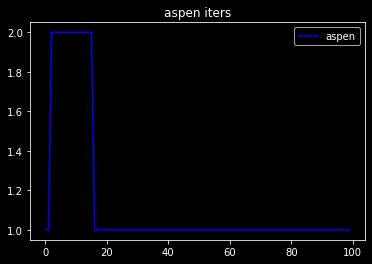

In [16]:
plt.title('aspen iters')
plt.plot(solver_m1.timelog.aspen_iters, color = 'b', label='aspen')
plt.legend()
plt.show()

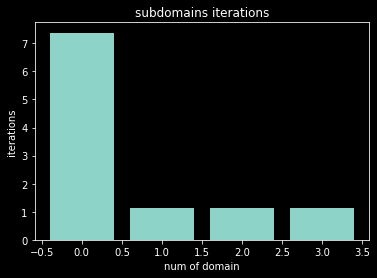

In [17]:
plt.title('subdomains iterations')
plt.xlabel('num of domain')
plt.ylabel('iterations')
plt.bar(np.arange(0, Nd, 1, dtype='int'), solver_m1.timelog.domain_iters)
plt.show()

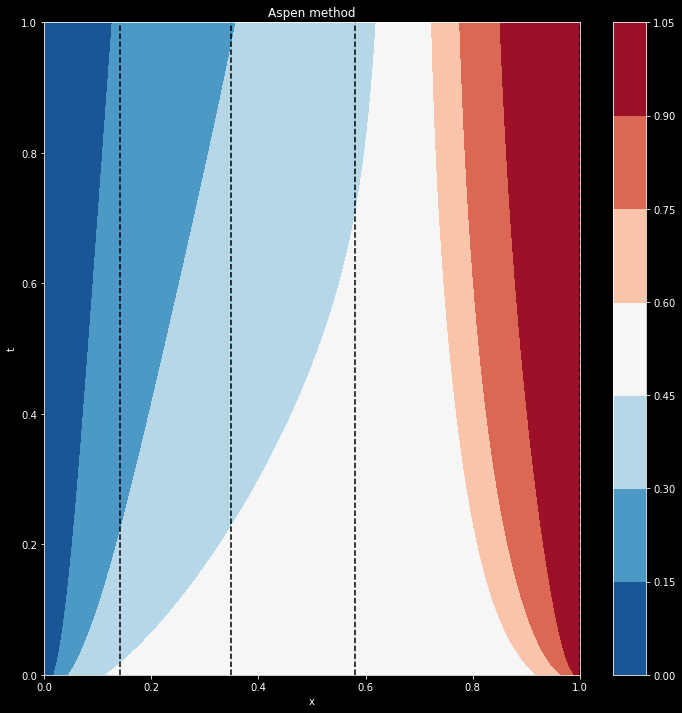

In [19]:
x = np.linspace(0, 1, Nx)
plt.figure(figsize= (12, 12))
plt.xlabel('x')
plt.ylabel('t')
plt.title('Aspen method')
t = solver_m1.t
x_grid, t_grid = np.meshgrid(x, t)
cs = plt.contourf(x_grid, t_grid, X.T, cmap='RdBu_r')
cbar = plt.colorbar(cs)
# plot domain borders
part = borders
for dom in part:
    plt.axvline(dom/Nx, linestyle='--', color='k')

plt.show()

Какой можно сделать вывод: данная метрика стремится локализовать области.

##### Метод 2 
$$
w(v, u) = |cov(u, v)|
$$
где u, v - столбцы по t

$$
	\sum_{i=1}^k \sum_{v \in V_i} \sum_{u \in \Gamma(v), u \notin V_i} \frac{w(v, u)}{k} \rightarrow min 
$$

In [20]:
def metrics_2(solver, X, domain_borders, t_step, show = False):
    nd = domain_borders.shape[0]-1
    val = 0
    
    for i in range(1, nd):
        dom = domain_borders[i]
        
        fr = X[dom-1, ::t_step].T
        sc = X[dom, ::t_step].T
        tmp = np.stack((fr, sc), axis = 0)
        cov = np.cov(tmp)
        val += np.abs(cov[0][1]/np.sqrt(cov[0][0]*cov[1][1]))

    return val

In [27]:
# start value
part = partion.partion_equally(Nx, Nd)
print(part)
borders = np.copy(part)

T0 = 9600
val_start = metrics_2(solver_cl, X, borders, 1, show=True)
val_prev = np.copy(val_start)

for k in range(0, 420, 2):
    T = T0/(1.05**k)
    borders_new = neighbour(borders)
    val = metrics_2(solver_cl, X, borders_new, 1)
    if (val < val_prev) or (np.random.rand() < np.exp(-(val-val_prev)/(0.01*T))):
        borders = np.copy(borders_new)
        val_prev = np.copy(val)
        
val_end = metrics_2(solver_cl, X, borders, 1, show=True)
print('before: {:.2f}'.format(val_start))
print('after: {:.2f}'.format(val_end))
if(val_start > val_end):
    print('it works!')
print(borders)


[   0  250  500  750 1000]
before: 3.00
after: 2.38
it works!
[   0  158  409  668 1000]


In [29]:
t_m2 = np.inf
for k in range(5):
    nl_solver = aspen(Nd, borders, 1e-2, crit_abs = 1e-3)
    solver_m2 = one_phase(param, D, nl_solver)
    solver_m2.init_log()
    solver_m2.setBoundary(bd1, bd2)
    solver_m2.x0 = np.copy(x0)
    #setInitial(solver_as)
    
    setSources(solver_m2)
    X, code, message = solver_m2.solve()
    
    t = solver_m2.timelog.gb_res+solver_m2.timelog.gb_jac \
      +solver_m2.timelog.gb_lin+np.sum(solver_m2.timelog.lc_res) \
      +np.sum(solver_m2.timelog.lc_jac)+np.sum(solver_m2.timelog.lc_lin)
    
    if t < t_m2:
        t_m2 = np.copy(t)
        
print(message)
print('mean aspen iterations: ', np.mean(solver_m2.timelog.aspen_iters))
print('best time', t_m2)

ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
OK
mean aspen iterations:  1.1
best time 61.52067518234253


In [30]:
m2_optimal = np.copy(val_end)

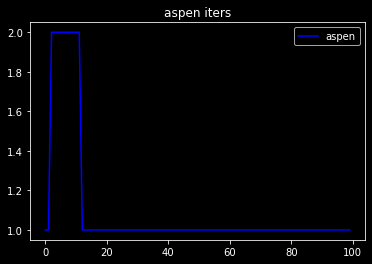

In [35]:
x = np.linspace(0, 1, Nx)
plt.title('aspen iters')
plt.plot(solver_m2.timelog.aspen_iters, color = 'b', label='aspen')
plt.legend()
plt.show()

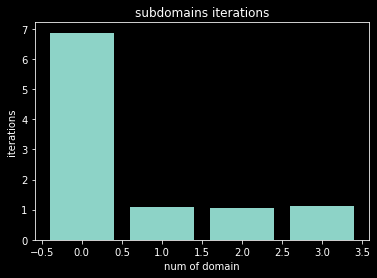

In [36]:
plt.title('subdomains iterations')
plt.xlabel('num of domain')
plt.ylabel('iterations')
plt.bar(np.arange(0, Nd, 1, dtype='int'), solver_m2.timelog.domain_iters)
plt.show()

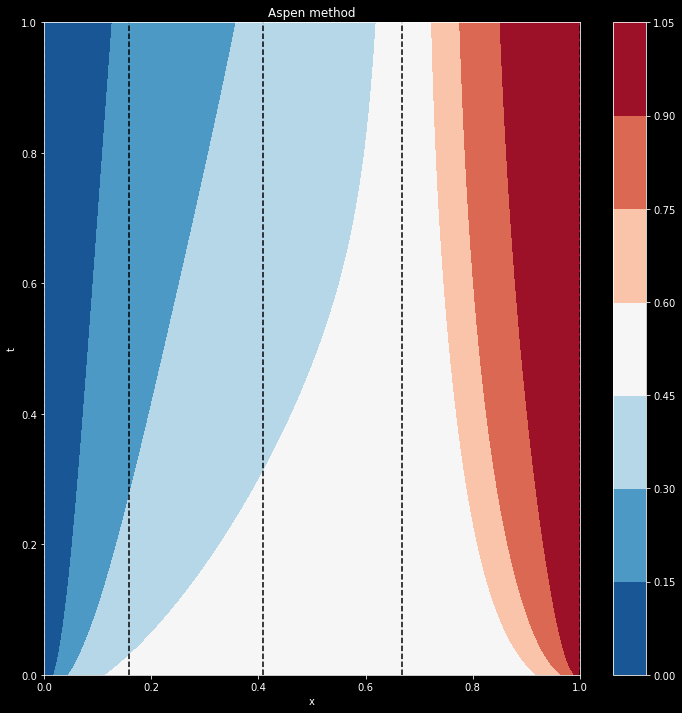

In [37]:
plt.figure(figsize= (12, 12))
plt.xlabel('x')
plt.ylabel('t')
plt.title('Aspen method')
t = solver_m2.t
x_grid, t_grid = np.meshgrid(x, t)
cs = plt.contourf(x_grid, t_grid, X.T, cmap='RdBu_r')
cbar = plt.colorbar(cs)
# plot domain borders
part = borders
for dom in part:
    plt.axvline(dom/Nx, linestyle='--', color='k')

plt.show()

##### Метод 3
$$
w(v, u) =  -det \frac{\partial (R(u), R(v))}{\partial (v, u)}
$$

$$
	\sum_{i=1}^k \sum_{v \in V_i} \sum_{u \in \Gamma(v), u \notin V_i} \frac{w(v, u)}{k} \rightarrow min
$$
Тут тоже идея навеяна корелляционным анализом

In [38]:
def metrics_3(solver, X, domain_borders, Nt, t_step, show = False):
    nd = domain_borders.shape[0]-1
    val = 0
    dt = 1/Nt
    for n_t in range(0, Nt+1, t_step):
        for i in range(1, nd):
            bd = domain_borders[i]
            val -= \
                (1/dt+solver.FluxJac(X[:, n_t], bd)[0, 0]-solver.FluxJac(X[:, n_t], bd-1)[0, 1])\
                *(1/dt+solver.FluxJac(X[:, n_t], bd+1)[0, 0]-solver.FluxJac(X[:, n_t], bd)[0, 1]) \
                + solver.FluxJac(X[:, n_t], bd)[0, 1] \
                * solver.FluxJac(X[:, n_t], bd)[0, 0]
                         #)

        #val /= (nd-1)
    val /= ((Nt+1)//t_step)

    return val

In [39]:
# start value
part = partion.partion_equally(Nx, Nd)
print(part)
borders = np.copy(part)

T0 = 19600
val_start = metrics_3(solver_cl, X, borders, Nt, 1, show=True)
val_prev = np.copy(val_start)
for k in range(0, 320, 1):
    T = T0/(1.1**k)
    borders_new = neighbour(borders)
    val = metrics_3(solver_cl, X, borders_new, Nt, 1)
    if (val < val_prev) or (np.random.rand() < np.exp(-(val-val_prev)/(T))):
        borders = np.copy(borders_new)
        val_prev = np.copy(val)

        
val_end = metrics_3(solver_cl, X, borders, Nt, 1, show=True)
m3_optimal = np.copy(val_end)
print('before: {:.2f}'.format(val_start))
print('after: {:.2f}'.format(val_end))
if(val_start > val_end):
    print('it works!')
print(borders)

[   0  250  500  750 1000]
before: -44939253741.47
after: -61040077102.39
it works!
[   0  178  346  624 1000]


In [40]:
t_m3 = np.inf
for k in range(5):
    nl_solver = aspen(Nd, borders, 1e-2, crit_abs = 1e-3)
    solver_m3 = one_phase(param, D, nl_solver)
    solver_m3.init_log()
    solver_m3.setBoundary(bd1, bd2)
    solver_m3.x0 = np.copy(x0)
    #setInitial(solver_as)
    setSources(solver_m3)

    X, code, message = solver_m3.solve()
    t = solver_m3.timelog.gb_res+solver_m3.timelog.gb_jac \
      +solver_m3.timelog.gb_lin+np.sum(solver_m3.timelog.lc_res) \
      +np.sum(solver_m3.timelog.lc_jac)+np.sum(solver_m3.timelog.lc_lin)
    if t < t_m3:
        t_m3 = np.copy(t)

print(message)
print('mean aspen iterations: ', np.mean(solver_m3.timelog.aspen_iters))

ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
OK
mean aspen iterations:  1.0


In [43]:
print('best time:', t_m3)

best time: 59.36325168609619


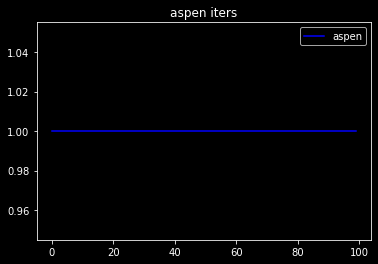

In [44]:
plt.title('aspen iters')
plt.plot(solver_m3.timelog.aspen_iters, color = 'b', label='aspen')
plt.legend()
plt.show()

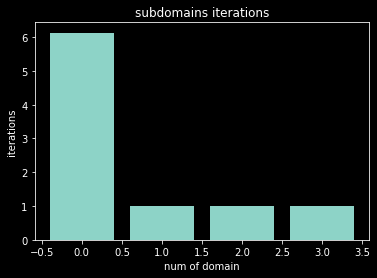

In [45]:
plt.title('subdomains iterations')
plt.xlabel('num of domain')
plt.ylabel('iterations')
plt.bar(np.arange(0, Nd, 1, dtype='int'), solver_m3.timelog.domain_iters)
plt.show()

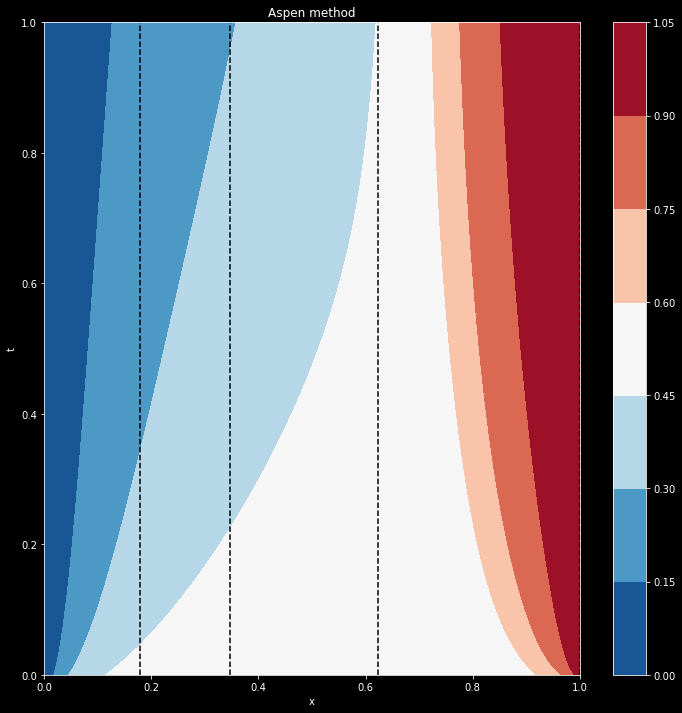

In [47]:
x = np.linspace(0, 1, Nx)
plt.figure(figsize= (12, 12))
plt.xlabel('x')
plt.ylabel('t')
plt.title('Aspen method')
t = solver_m3.t
x_grid, t_grid = np.meshgrid(x, t)
cs = plt.contourf(x_grid, t_grid, X.T, cmap='RdBu_r')
cbar = plt.colorbar(cs)
# plot domain borders
part = borders
for dom in part:
    plt.axvline(dom/Nx, linestyle='--', color='k')

plt.show()

In [56]:
print('---compareison---')
print('-eq-vs-m1-vs-m2-vs-m3-')

print('{:.4}'.format(t_eq),
     '{:.4}'.format(t_m1),
     '{:.4}'.format(t_m2),
     '{:.4}'.format(t_m3)
     )

---compareison---
-eq-vs-m1-vs-m2-vs-m3-
65.92 60.48 61.52 59.36


#### Вывод: лучшая метрика по критерию времени работы - m3

##### Тест на рандомных границах

In [58]:
def generate_random(Nx, Nd, min_size=10):
    size = 0
    while(size < min_size):
        choice = 10+np.random.choice(Nx-10, Nd-1)
        choice = np.sort(choice)
        size = np.min(choice[1:] - choice[:-1])
    return np.concatenate(([0], choice , [Nx]), axis = 0)

In [59]:
import csv

gather_data = False
if gather_data:
    N = 150
    Nd = 4
    param = {
        'Nx': Nx, 
        'Nt': Nt,
        'Nd': Nd
    }

    time = np.zeros(N)
    borders = np.zeros((Nd-1, N), dtype = 'int')
    num_of_alghs = 0

    for k in range(N):
        part = generate_random(Nx, Nd)
        borders[:, k] = part[1:-1]
        nl_solver = aspen(Nd, part, 1e-2, crit_abs = 1e-3)
        solver_ts = one_phase(param, D, nl_solver)
        solver_ts.init_log(show = False)
        solver_ts.setBoundary(bd1, bd2)
        solver_ts.x0 = np.copy(x0)
        #setInitial(solver_as)
        setSources(solver_ts)

        _, _, message = solver_ts.solve()
        if(message != 'OK'):
            continue
        t = solver_ts.timelog.gb_res+solver_ts.timelog.gb_jac \
          +solver_ts.timelog.gb_lin+np.sum(solver_ts.timelog.lc_res) \
          +np.sum(solver_ts.timelog.lc_jac)+np.sum(solver_ts.timelog.lc_lin)
        time[k] = t
        num_of_alghs += 1
        
        # save data

        name = 'Nx={},Nt={},Nd={}.csv'.format(Nx, Nt, Nd)
        
        filt = time > 0

        with open(name, 'a') as csvfile:
            writer = csv.writer(csvfile, delimiter=',')
            writer.writerows(borders[filt])
            writer.writerow(time[filt])
else:
    name = 'Nx={},Nt={},Nd={}.csv'.format(Nx, Nt, Nd)


    with open(name, 'r') as csvfile:
        reader = csv.reader(csvfile)
        data = []
        for row in reader:
            data.append(row)
        
        borders = np.array(data[0:Nd-1], dtype='int')
        time = np.array(data[Nd-1], dtype= 'float')
        num_of_alghs = np.sum(time > 0)

In [60]:
print('Numner og alghorithms that converged:', num_of_alghs)
print('mean time :', np.sum(time)/num_of_alghs)
sq_cov = np.sqrt(np.sum(time**2)/num_of_alghs-(np.sum(time)/num_of_alghs)**2)
print('sqrt cov :', np.sqrt(np.sum(time**2)/num_of_alghs-(np.sum(time)/num_of_alghs)**2))

Numner og alghorithms that converged: 124
mean time : 73.19107317539954
sqrt cov : 15.016313974396432


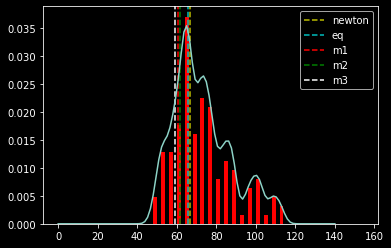

66.83894205093384 65.92048025131226 60.48191690444946 61.52067518234253 59.36325168609619


In [63]:
from scipy.stats import gaussian_kde
from scipy.integrate import quad

width = 4
win = np.arange(5, 155, width)
y = []
for x in win:
    mask = ((time < x+width/2) & (time > (x - width/2)))
    y.append(np.sum(mask)/ num_of_alghs/5)
    
plt.bar(win, y, width=width*0.5, color = 'r')
bw = 1/(1.06*sq_cov)*num_of_alghs**(1/5)
filt = time > 0
kernel = gaussian_kde(time[filt], bw_method=bw)

plt.axvline(t_new, label='newton', linestyle ='--', color='y')
plt.axvline(t_eq, label='eq', linestyle ='--', color='c')
plt.axvline(t_m1, label='m1', linestyle ='--', color ='r')
plt.axvline(t_m2, label='m2', linestyle ='--', color ='g')
plt.axvline(t_m3, label='m3', linestyle ='--', color ='w')

plt.plot(np.linspace(0, 140, 100), kernel(np.linspace(0, 140, 100)))
plt.legend()
plt.show()

print(t_new, t_eq, t_m1, t_m2, t_m3)

In [65]:
# we will estimate the efficency by function of distibution
p_eq, err_eq = quad(kernel, 0, t_eq)
print('equally partion : {}'.format(p_eq))
p_m1, err_m1 = quad(kernel, 0, t_m1)
print('m1 partion : {}'.format(p_m1))
p_m2, err_m2 = quad(kernel, 0, t_m2)
print('m2 partion : {}'.format(p_m2))
p_m3, err_m3 = quad(kernel, 0, t_m3)
print('m3 partion : {}'.format(p_m3))

equally partion : 0.37231068176996324
m1 partion : 0.19773083874265338
m2 partion : 0.2254123031989458
m3 partion : 0.17118260531406498


---random partions better than m3---


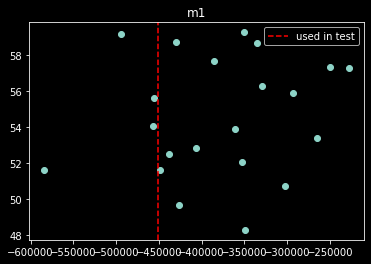

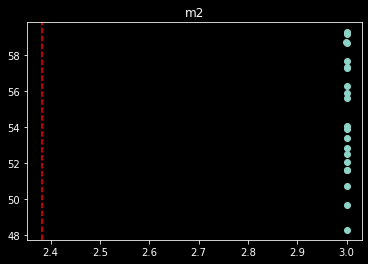

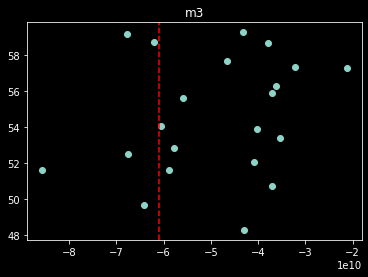

--the best partion--
[372 446 635]


In [68]:
# let's find out what's good about partions better than m1

ind = np.argwhere((time < t_m3) & (time > 0) )
print('---random partions better than m3---')
m1_list = []
m2_list = []
m3_list = []
for i in ind:
    part = np.concatenate(([0], borders[:, i].flatten() , [Nx]), axis = 0)
    metrics1 = metrics_1(solver_cl, X, part, Nt, 1)
    metrics2 = metrics_2(solver_cl, X, part, 1)
    metrics3 = metrics_3(solver_cl, X, part, Nt, 1)
    m1_list.append(metrics1)
    m2_list.append(metrics2)
    m3_list.append(metrics3)
    #print(borders[:, i].T, 'time = {:.3}'.format(time[i][0]), ', m1={:.4E}'.format(metrics1))

plt.title('m1')
plt.scatter(m1_list, time[ind])
plt.axvline(m1_optimal, linestyle='--', color='r', label='used in test')
plt.legend()
plt.show()
plt.title('m2')
plt.axvline(m2_optimal, linestyle='--', color='r', label='used in test')
plt.scatter(m2_list, time[ind])
plt.show()
plt.title('m3')
plt.axvline(m3_optimal, linestyle='--', color='r', label='used in test')
plt.scatter(m3_list, time[ind])
plt.show()

print('--the best partion--')

best = np.argmin(time[time > 0])
print(borders[:, best])

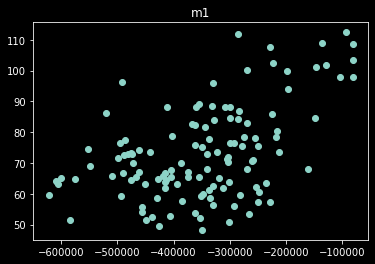

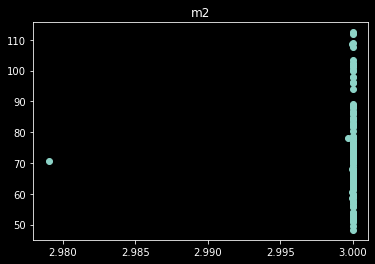

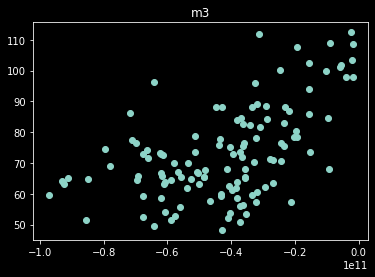

In [69]:
filt = time > 0
metrics1 = []
metrics2 = []
metrics3 = []

for domain in borders[:, filt].T:
    part = np.concatenate(([0], domain, [Nx]), axis = 0)
    metrics1.append(metrics_1(solver_cl, X, part, Nt, 1))
    metrics2.append(metrics_2(solver_cl, X, part, 1))
    metrics3.append(metrics_3(solver_cl, X, part, Nt, 1))

metrics1 = np.array(metrics1)
metrics2 = np.array(metrics2)
metrics3 = np.array(metrics3)

plt.title('m1')
plt.scatter(metrics1, time[filt])
plt.show()
plt.title('m2')
plt.scatter(metrics2, time[filt])
plt.show()
plt.title('m3')
plt.scatter(metrics3, time[filt])
plt.show()

In [70]:
cov_m1 = np.cov(np.stack((time[filt], metrics1) , axis = 0))

print('---cov_m (time, m1_value)---')
print(cov_m1)
print('---cov(time, m1_value) / sqrt(var(m1_value)*var(time))---')
print('m1 :', cov_m1[0, 1]/np.sqrt(cov_m1[1, 1])/np.sqrt(cov_m1[0, 0]))

cov_m2 = np.cov(np.stack((time[filt], metrics2) , axis = 0))

print('---cov_m (time, m2_value)---')
print(cov_m2)
print('---cov(time, m2_value) / sqrt(var(m2_value)*var(time))---')
print('m1 :', cov_m2[0, 1]/np.sqrt(cov_m2[1, 1])/np.sqrt(cov_m2[0, 0]))

cov_m3 = np.cov(np.stack((time[filt], metrics3) , axis = 0))

print('---cov_m (time, m3_value)---')
print(cov_m3)
print('---cov(time, m2_value) / sqrt(var(m2_value)*var(time))---')
print('m3 :', cov_m3[0, 1]/np.sqrt(cov_m3[1, 1])/np.sqrt(cov_m3[0, 0]))

---cov_m (time, m1_value)---
[[2.27322935e+02 9.36646257e+05]
 [9.36646257e+05 1.49570992e+10]]
---cov(time, m1_value) / sqrt(var(m1_value)*var(time))---
m1 : 0.5079609045749189
---cov_m (time, m2_value)---
[[2.27322935e+02 3.71187343e-04]
 [3.71187343e-04 3.54839699e-06]]
---cov(time, m2_value) / sqrt(var(m2_value)*var(time))---
m1 : 0.013069393387311333
---cov_m (time, m3_value)---
[[2.27322935e+02 1.81018222e+11]
 [1.81018222e+11 4.78564858e+20]]
---cov(time, m2_value) / sqrt(var(m2_value)*var(time))---
m3 : 0.5488204245473031


#### Вывод: третья метрика кажется лучше, т.к. она а) дает лучше результат по времени, б) лучше корреллирует 